# Testes com busca (euclidean distances) utilizando feature extraction da Rede Siamesa

In [1]:
from collections import Counter
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time


caminho_bases = os.path.join('..', 'bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

SIZE = (224, 224)

# Recupera imagens

In [2]:
datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=1024,
    class_mode='binary',
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=512,
    class_mode='binary',
    shuffle=True
)

Found 20845 images belonging to 2 classes.
Found 2317 images belonging to 2 classes.


# Models

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D


SIZE = (224, 224)


nuclear_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Flatten(),
  Dense(128, activation='relu'),
 
])

nuclear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [4]:
a_in = Input(shape=(*SIZE, 3))
b_in = Input(shape=(*SIZE, 3))

a_feat = nuclear_model(a_in)
b_feat = nuclear_model(b_in)

combined_features = concatenate([a_feat, b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.Model(inputs = [a_in, b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()



Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          1064608     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 256)          0           sequential[1][0]  

In [5]:
MODEL_DIR = '../models/siamese'
epoch = 6
val_loss = 0.24

similarity_model.load_weights(os.path.join(
    MODEL_DIR, 
    '04modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
    )
)


In [29]:
batch, labels = next(validation_generator)

print('Tempo para predição em %d imagens' % len(batch))
%time features_batch = nuclear_model.predict(batch)

Tempo para predição em 512 imagens
CPU times: user 439 ms, sys: 149 ms, total: 589 ms
Wall time: 582 ms


In [7]:
%%time
ind = random.randint(0, len(features_batch))
distances = euclidean_distances([features_batch[ind]], features_batch)
sequence = np.argsort(distances)[0]
print(ind, sequence)

376 [376 328  22 332  89 364 169 508 264 234  99 503 108   2 298 314 223  46
  17 369 497  47 493  76 411 186 247 326  97 474 183 178 378  82  81  58
 487 269 333 170 302 398  20 203 388 229 338 375  14 368 499 237  54 155
 351 198 476 396 481  88 397 109 145 406 216 380  56  80  53 423 233 255
 181 308 436 483  28 144  24  72 372 137 115 404 113 413 100 206 353   7
 103 116 172 194 371 460 471 287 162 414 168  34 118 400 101 421 243  94
 124  30 248 502 205 185 457 370 478 257 374  26  68 386 294 254 134 291
 152 114 435 387  93   9 231 429 276 263 415 438 362 486 188 417 235  95
 275 492 204 221 126 250  62 182  36 403  87 239 289 240 246 171 348 192
 262 279  31  39 242 265  38 425 337 464 128  59 299   6 467 360  61 111
  21 450  42 432 149 131 342 238 491  90 336 270 195 160   8 431 313 179
 366 320 187 383 440 389 138 282  73 339 258 199 506 507 290 390 510 446
 266 200  67 295 395 304  63 141  50  84  49 410 127 392 426 419 490 355
 157 285 345 509 391 321  37 322 305 154 442 34

In [8]:
print(labels[ind], labels[sequence] )

1.0 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

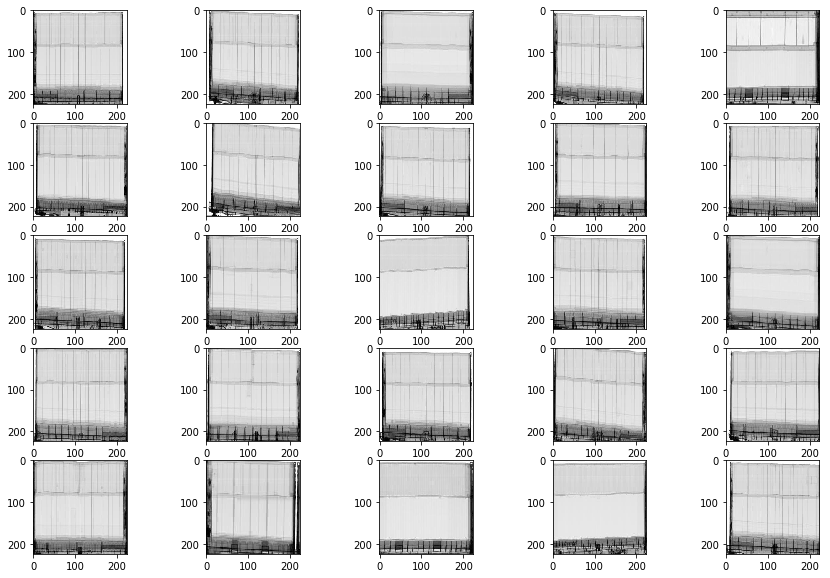

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for row in range(5):
    for col in range(5):
        img_ind = row * 5 + col
        axes[col, row].imshow(batch[sequence[img_ind]])


In [19]:
ind = random.randint(0, len(features_batch))
distances = euclidean_distances([features_batch[ind]], features_batch)
sequence = np.argsort(distances)[0]
print(ind, sequence)

40 [ 40  44  12 123 174 300 253 267 346 249 488 418  96   3 213 469 278 147
 130 256 176  83 310 296  18 344 232 105 142 215 217 277  69 180 120  65
 119 297 225 153 129 437 251  91 331 315 177 458 140  60 451 365 283 219
 422 428 480 354 252 148 218 236 385   1  57 393 334  64 271 196 244 214
 167 230 208  52   5 377 224  70 143 424 373  92 441 222 477 505 197 133
 175 447 288 193 228   0 453 475 104 122 358  23 132 456 212 340 121 241
  98 150 311 452 459 462 485 163 363 173 261 335  16 466 498 107 280 430
 245  43 495  55 318 227 151 379 407 511 494 190 399  78  19  74 504 394
 286 117 445 319 136 209 220 260 382  13 284 189 449 166 329 416  15  10
 357 468 472  41  77 273 306  11 312 433 165 226 496  71 303  86 361 184
 102 125 408 349  29  27 434 135 159 501 210 352 292 427 350 158 465 448
 316 293 405 489 110 268 202 384 164  85 347  48  79  33 367  25 473 323
  51 309 482 146 112 412 444 454 443 201 301 409 327 500 461 420  32 259
 191 211 156 359 463  66 281 161 330 341 479 484

In [20]:
print(labels[ind], labels[sequence])

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

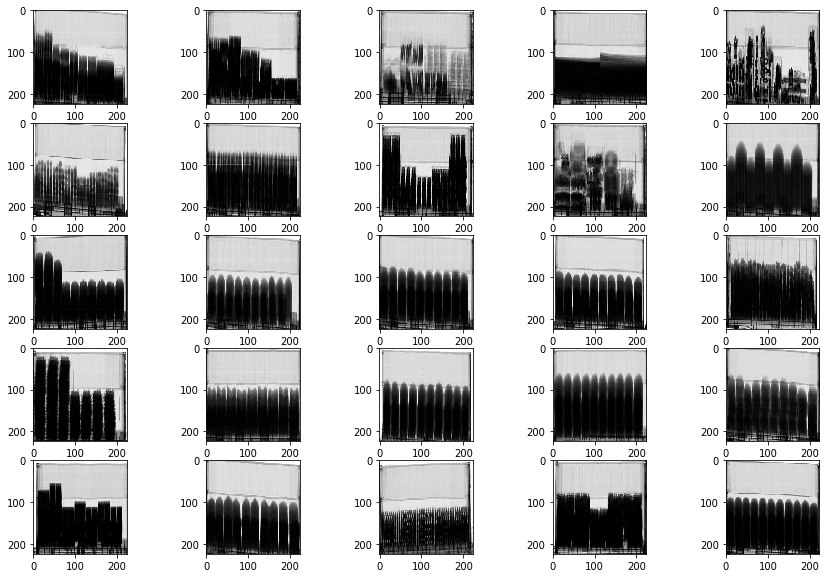

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for row in range(5):
    for col in range(5):
        img_ind = row * 5 + col
        axes[col, row].imshow(batch[sequence[img_ind]])


In [22]:
def get_batch(generator, model=nuclear_model):
    batch, labels = next(validation_generator)
    features_batch = model.predict(batch)
    return features_batch, labels
    
def get_sequence(features, ind, cosine=False):
    if cosine:
        distances = euclidean_distances([features[ind]], features)
    else:
        distances = euclidean_distances([features[ind]], features)
    sequence = np.argsort(distances)[0]
    return sequence


In [23]:
ROUNDS = 200
# Coincidências de classe em 10 itens
train_generator.reset()
for r in range(1, 6):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:10])
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 10)))


Acertos no batch 1: 0.93
Acertos no batch 2: 0.91
Acertos no batch 3: 0.95
Acertos no batch 4: 0.94
Acertos no batch 5: 0.94


In [24]:
validation_generator.reset()

total_acertos = 0
tentativas = 0 


for r in range(1, 6):
    X, y = get_batch(validation_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:10])
        # print(s, acertos)
        acerto_batch += acertos
        tentativas += 1
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 10) ))
    total_acertos += acerto_batch

    
print('Geral: {:0.2f}'.format(total_acertos / (tentativas * 10) ))


Acertos no batch 1: 0.94
Acertos no batch 2: 0.93
Acertos no batch 3: 0.94
Acertos no batch 4: 0.93
Acertos no batch 5: 0.93
Geral: 0.93


In [25]:
# USANDO COSINE SIMILARITY

validation_generator.reset()

total_acertos = 0
tentativas = 0 


for r in range(1, 6):
    X, y = get_batch(validation_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind, cosine=True)
        acertos = sum(y[ind] ==  y[seq][:10])
        # print(s, acertos)
        acerto_batch += acertos
        tentativas += 1
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 10) ))
    total_acertos += acerto_batch

    
print('Geral: {:0.2f}'.format(total_acertos / (tentativas * 10) ))


Acertos no batch 1: 0.95
Acertos no batch 2: 0.93
Acertos no batch 3: 0.96
Acertos no batch 4: 0.93
Acertos no batch 5: 0.95
Geral: 0.95


In [26]:
# Coincidências de classe em 20 itens

total_acertos = 0
tentativas = 0 

train_generator.reset()
for r in range(1, 11):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:20])
        # print(s, acertos)
        acerto_batch += acertos
        tentativas += 1
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 20)))
    total_acertos += acerto_batch

    
print('Geral: {:0.2f}'.format(total_acertos / (tentativas * 20) ))


Acertos no batch 1: 0.91
Acertos no batch 2: 0.92
Acertos no batch 3: 0.95
Acertos no batch 4: 0.89
Acertos no batch 5: 0.95
Acertos no batch 6: 0.95
Acertos no batch 7: 0.90
Acertos no batch 8: 0.92
Acertos no batch 9: 0.93
Acertos no batch 10: 0.94
Geral: 0.93


In [27]:
# Coincidências de classe em 20 itens - por classe
train_generator.reset()
acerto_total = Counter()
total = Counter()
for r in range(1, 11):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:20])
        total[y[ind]] += 20
        acerto_total[y[ind]] += acertos
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 20)))


Acertos no batch 1: 0.94
Acertos no batch 2: 0.90
Acertos no batch 3: 0.96
Acertos no batch 4: 0.91
Acertos no batch 5: 0.92
Acertos no batch 6: 0.96
Acertos no batch 7: 0.95
Acertos no batch 8: 0.89
Acertos no batch 9: 0.91
Acertos no batch 10: 0.95


In [28]:
print('0 = não vazio\n1 = vazio')
for classe in [0, 1]:
    print('Acerto classe {}: {:d} de {:d} ({:0.2f})'.format(
           classe, acerto_total[classe], total[classe],
           (acerto_total[classe] / total[classe]) )
         )


0 = não vazio
1 = vazio
Acerto classe 0: 18862 de 20420 (0.92)
Acerto classe 1: 18302 de 19580 (0.93)
